In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Layer, LSTM, Dense, Dropout, Flatten, AdditiveAttention, Permute, Reshape, Multiply, BatchNormalization
from downloadStockSp500Prices import get_stock_data, get_stock_test_data, predict_stock_price
from helpers import create_sequential_data, get_test_data
import matplotlib.pyplot as plt

In [2]:
# Hyperparameter
window_size = 60 # timesteps, in days (this is a hyperparameter)

# Number of future days to predict
predict_days = 4

stock_symbol = "AAPL"
# Train data start and end date period
start_str = "2022-01-01"
end_str = "2023-03-01"

get_stock_data(stock_symbol, start_date=start_str, end_date=end_str)

# Convert timestamp string to datetime object - we want the test data to be end date + window size + future days we are predicting
# Ex. if window size is 60, and we want to predict 4 days after our train data ends, we want 64 days after the end date
end_timestamp = datetime.strptime(end_str, "%Y-%m-%d")

# Start of test data (one day after train data end date)
test_start_timestamp = end_timestamp + timedelta(days=1)

# trading_days = window_size + predict_days

# # get test data - we need number of timesteps (ex. 60) plus future days (ex. 4) that we are predicting 
# # (NOTE: Not the same as predicting a sequence of days at once, the LSTM should still predict just one future day based on the window)
# get_stock_test_data(stock_symbol, test_start_timestamp, trading_days)

[*********************100%%**********************]  1 of 1 completed


In [3]:
# Load Train data
data = pd.read_csv("AAPL_stock_data.csv")
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-01-03,177.830002,182.880005,177.710007,182.009995,179.273605,104487900
1,2022-01-04,182.630005,182.940002,179.119995,179.699997,176.998337,99310400
2,2022-01-05,179.610001,180.169998,174.639999,174.919998,172.290176,94537600
3,2022-01-06,172.699997,175.300003,171.639999,172.000000,169.414124,96904000
4,2022-01-07,172.889999,174.139999,171.029999,172.169998,169.581543,86709100


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290 entries, 0 to 289
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       290 non-null    object 
 1   Open       290 non-null    float64
 2   High       290 non-null    float64
 3   Low        290 non-null    float64
 4   Close      290 non-null    float64
 5   Adj Close  290 non-null    float64
 6   Volume     290 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 16.0+ KB


In [5]:
data["Close"] = pd.to_numeric(data.Close, errors="coerce")
data = data.dropna()
trainData = data.iloc[:,4:5].values # Only use Close column values as training data
trainData.reshape(-1,1).shape # Reshape first dimension so it goes from matrix to a column vector (number of rows is implicitly inferred)

(290, 1)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290 entries, 0 to 289
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       290 non-null    object 
 1   Open       290 non-null    float64
 2   High       290 non-null    float64
 3   Low        290 non-null    float64
 4   Close      290 non-null    float64
 5   Adj Close  290 non-null    float64
 6   Volume     290 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 16.0+ KB


In [7]:
# Rescale data to be between 0 and 1 for better perfomance/normalization
sc = MinMaxScaler(feature_range=(0,1))
trainData = sc.fit_transform(trainData) # scale data to be between 0 and 1
trainData.shape

(290, 1)

In [8]:
X_train = []
y_train = []

predict_days = 0

predict_multipledays = True if (predict_days > 1) else False

# get our data that has a sliding window applied to it, where y represents the next day after the interval of window_size days for each X sample
# TODO: Create sliding window in create_sequential_data that moves up by more than 1 day, less overfitting
# X - (samples, window_size), y - (samples, 1)
X, y = create_sequential_data(trainData, window_size)
print(X.shape, y.shape)

# Test train split
# NOTE: Test size does not represent the number of days (raw data), it is the number of days we want to predict from all our windows in X
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
print(test_size)

# X_train, X_test = X[:train_size], X[train_size:]
# y_train, y_test = y[:train_size], y[train_size:]

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)
print(X_test.shape, y_test.shape)

# This code below is optional, but the total number of samples must be divisible by window_size and future_days
# Data is in the shape of (samples, timesteps, features), where samples is implicitly determined input_shape is (timesteps, features)
# X_train = X_train.reshape(-1, window_size, 1) # implicitly figures out number of samples for batch dimension based on total data samples
#y_train = y_train.reshape(-1, predict_days)
# print(X_train.shape, y_train.shape)

# Add batch size axis for input into LSTM - Data is in the shape of (samples, timesteps, features), where input_shape is (timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) # Last 1 indicates have one feature (the price) in each timestep
X_train.shape, y_train.shape

(230, 60) (230,)
46
(46, 60) (46,)


((184, 60, 1), (184,))

In [9]:
#TODO: Move Reshape into Attention class Forward, add comments what output looks like of reshape

class AdditiveAttentionLayer(Layer):
    def __init__(self):
        super(AdditiveAttentionLayer, self).__init__()
        self.attention = AdditiveAttention(name='attention_weight')

    def call(self, inputs):
        attention_result = self.attention([inputs, inputs])
        return attention_result

In [10]:
model = Sequential()

model.add(LSTM(units=100, return_sequences=True, input_shape = (X_train.shape[1], 1))) # don't specify batch dimension (first dimension)
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))

# if (predict_multipledays):
model.add(LSTM(units=100, return_sequences=True))
# else:
#     # final LSTM layer does not return sequences as we prepare data for the attention layer
#     model.add(LSTM(units=100))
model.add(Dropout(0.2))

# Permute and reshape for compatibility
model.add(Permute((2, 1))) 
model.add(Reshape((-1, X_train.shape[1])))
# Self-attention mechanism
#attention = AdditiveAttention(name='attention_weight')
attention_layer = AdditiveAttentionLayer()
model.add(attention_layer)
#model.add(attention)
#result = attention([model.output, model.output])
#multiply_layer = Multiply()([model.output, attention.output])
#attention_output = model.output
# Return to original shape
# Add Multiply layer taking the output of the CustomAdditiveAttentionLayer
#multiply_layer = Multiply()([attention_output, attention_output])

# Add the Multiply layer to the model
#model.add(multiply_layer)
model.add(Permute((2, 1)))
model.add(Reshape((-1, 50)))

# Dropout and Batch Normalization
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Flatten()) # Flatten into a one dimensional vector

# if (predict_multipledays):
#     model.add(Dense(y_train.shape[1], activation='linear')) # number of timesteps per sample
# else:
model.add(Dense(units=1, activation='relu')) # Regression output for last value prediction

model.compile(optimizer='adam', loss='mean_squared_error')

# # Sentiment analysis - Add the classification output
# model.add(Dense(1, activation='sigmoid'))  # Binary classification output

# # Compile the model - both sentiment analysis and predict last day
# model.compile(optimizer='adam',
#               loss={'dense_1': 'binary_crossentropy', 'dense_2': 'mse'},
#               metrics={'dense_1': 'accuracy', 'dense_2': 'mse'})

# # Train the model
# model.fit(X_train, {'dense_1': y_class_train, 'dense_2': y_pred_train},
#           epochs=50, batch_size=32,
#           validation_data=(X_test, {'dense_1': y_class_test, 'dense_2': y_pred_test}))

# model = Sequential()
# #l1 = Input(shape=input_shape)
# l2 = LSTM(units=50, return_sequences=True, input_shape = (X_train.shape[1], 1))
# l3 = LSTM(units=50, return_sequences=True)
# l4 = Permute((2, 1))
# l5 = Reshape((-1, X_train.shape[1]))
# l6 = AdditiveAttention(name='attention_weight')([l5.output, l5.output])
# l7 = Permute((2, 1))(l6.output)
# l8 = Reshape((-1, 50))(l7.output)
# l9 = Flatten()(l8.output)
# l10 = Dense(1)(l9.output)
# l11 = Dropout(0.2)(l10.output)
# l12 = BatchNormalization()(l11.output)
# model = Sequential(l2, l3, l4, l5, l6, l7, l8, l9, l10, l11, l12)

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           40800     
                                                                 
 dropout (Dropout)           (None, 60, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 100)           80400     
                                                                 
 dropout_1 (Dropout)         (None, 60, 100)           0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 100)           80400     
                                                                 
 dropout_2 (Dropout)         (None, 60, 100)           0         
                                                                 
 lstm_3 (LSTM)               (None, 60, 100)          

In [11]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10) # 10 timesteps in a row validation loss does not decrease

hist = model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=2, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/20

5/5 - 7s - loss: 0.1209 - val_loss: 0.1028 - 7s/epoch - 1s/step
Epoch 2/20
5/5 - 1s - loss: 0.0542 - val_loss: 0.0790 - 841ms/epoch - 168ms/step
Epoch 3/20
5/5 - 1s - loss: 0.0627 - val_loss: 0.0720 - 828ms/epoch - 166ms/step
Epoch 4/20
5/5 - 1s - loss: 0.0404 - val_loss: 0.0698 - 823ms/epoch - 165ms/step
Epoch 5/20
5/5 - 1s - loss: 0.0378 - val_loss: 0.0663 - 826ms/epoch - 165ms/step
Epoch 6/20
5/5 - 1s - loss: 0.0320 - val_loss: 0.0619 - 811ms/epoch - 162ms/step
Epoch 7/20
5/5 - 1s - loss: 0.0345 - val_loss: 0.0611 - 813ms/epoch - 163ms/step
Epoch 8/20
5/5 - 1s - loss: 0.0295 - val_loss: 0.0546 - 816ms/epoch - 163ms/step
Epoch 9/20
5/5 - 1s - loss: 0.0268 - val_loss: 0.0509 - 819ms/epoch - 164ms/step
Epoch 10/20
5/5 - 1s - loss: 0.0279 - val_loss: 0.0487 - 819ms/epoch - 164ms/step
Epoch 11/20
5/5 - 1s - loss: 0.0264 - val_loss: 0.0429 - 813ms/epoch - 163ms/step
Epoch 12/20
5/5 - 1s - loss: 0.0257 - val_loss: 0.0417 - 805ms/epoch - 161ms/step
Epoch 13/20
5/5 - 1s - loss: 0

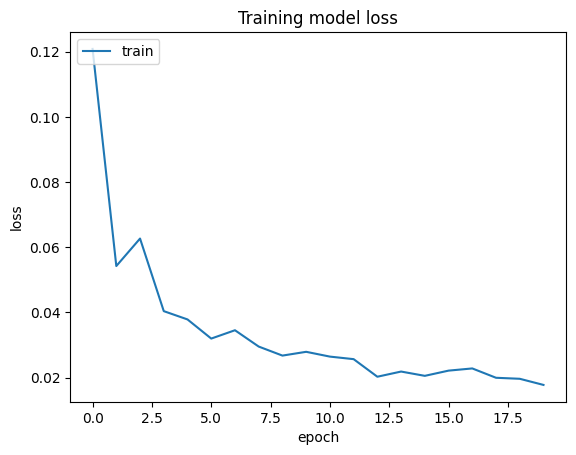

In [12]:
plt.plot(hist.history['loss'])
plt.title("Training model loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [13]:
## Test against real data that take place timesteps + future days + 1 after train data end date

# Get the test data (scaled) for prediction and actual stock prices from the test CSV file
#y_pred, X_pred = get_test_data(stock_symbol)
print(y_test.shape, X_test.shape)

# Predict the next 4 days iteratively
#predicted_prices = []
#current_batch = X_test[-window_size:].reshape(1, 60, 1)  # Most recent timesteps days, ex. 60 days
X_test.shape

# Add batch size axis to test data from test train split at beginning for input into LSTM
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1)) # Last 1 indicates have one feature (the price) in each timestep
X_test.shape

# Now evaluate the model on the test data, and get the MSE metric we specified in model.compile()
test_loss = model.evaluate(X_test, y_test)
print("Test Loss: ", test_loss)

(46,) (46, 60)
2/2 [==============================] - 0s 31ms/step - loss: 0.0261
Test Loss:  0.026063162833452225


In [14]:
y_pred = model.predict(X_test)
print(y_pred.shape, y_test.shape)
error = mean_squared_error(y_test, y_pred, squared=True)

print("Mean Squared Error: ", error)

# predicted_prices = sc.inverse_transform(y_pred)
# predicted_prices.shape
# np.squeeze(predicted_prices, 0).shape

2/2 [==============================] - 1s 29ms/step
(46, 1) (46,)
Mean Squared Error:  0.026063161616638367


c:\Users\justhess\OneDrive - Agilent Technologies\Documents\Python\Stocks\venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [15]:
# # get test data - we need number of timesteps (ex. 60) plus future days (ex. 4) that we are predicting 
# # (NOTE: Not the same as predicting a sequence of days at once, the LSTM should still predict just one future day based on the window)
# get_stock_test_data(stock_symbol, test_start_timestamp, trading_days)

# actual_stock_prices, X_pred = get_test_data(stock_symbol)
# actual_stock_prices.shape, X_pred.shape

data = predict_stock_price(stock_symbol, end_timestamp, window_size)

# Prepare the data
closing_prices = data['Close'].values[-window_size:]  # Last window_size days, ex. 60 days
closing_prices.shape

[*********************100%%**********************]  1 of 1 completed


(60,)

In [16]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_prices.reshape(-1, 1))

# Make predictions
predicted_prices = []
current_batch = scaled_data.reshape(1, window_size, 1)

for i in range(4):  # Predicting 4 days
    next_prediction = model.predict(current_batch)
    # Add the batch dimension to the prediction (1, 1)
    next_prediction_reshaped = next_prediction.reshape(1, 1, 1)
    # Iteratively get all the data after the first index and append the next prediction to it on the timestep dimension (second)
    current_batch = np.append(current_batch[:, 1:, :], next_prediction_reshaped, axis=1)
    predicted_prices.append(scaler.inverse_transform(next_prediction)[0, 0])

# Output the predictions
for i, price in enumerate(predicted_prices, 1):
    print(f"Day {i} prediction: {price}")

1/1 [==============================] - 0s 26ms/step
Day 1 prediction: 134.34156799316406
Day 2 prediction: 134.28968811035156
Day 3 prediction: 134.2279815673828
Day 4 prediction: 134.1542205810547


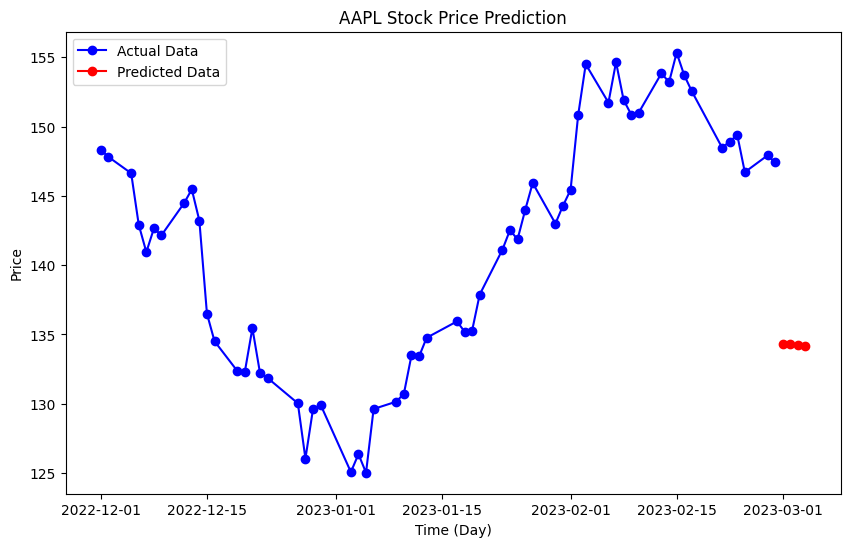

In [17]:
# Creating a list of dates for the predictions
last_date = data.index[-1]
next_day = last_date + pd.Timedelta(days=1)
prediction_dates = pd.date_range(start=next_day, periods=4)

# Adding predictions to the DataFrame
predicted_data = pd.DataFrame(index=prediction_dates, data=predicted_prices, columns=['Close'])

# Combining both actual and predicted data
combined_data = pd.concat([data['Close'], predicted_data['Close']])

# Last 60 days of actual data + 4 days of predictions
predict_days_num = window_size + 4
combined_data = combined_data[-predict_days_num:]

# Plotting the actual data
plt.figure(figsize=(10,6))
plt.plot(data.index[-window_size:], data['Close'][-window_size:], linestyle='-', marker='o', color='blue', label='Actual Data')

# Plotting the predicted data
plt.plot(prediction_dates, predicted_prices, linestyle='-', marker='o', color='red', label='Predicted Data')

plt.title(f"{stock_symbol} Stock Price Prediction")
plt.xlabel('Time (Day)')
plt.ylabel('Price')
plt.legend()
plt.show()


# plt.plot(actual_stock_prices, color = 'blue', label = 'Actual Stock Prices')
# plt.plot(np.squeeze(predicted_prices, 0), color = 'red', label = 'Predicted Stock Prices')
# plt.title(f"{stock_symbol} Stock Price Prediction")
# plt.xlabel('Time (Day)')
# plt.ylabel('Price')
# plt.legend()
# plt.show()